In [1]:
import pandas as pd
import tensorflow as tf 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model, save_model
from tensorflow.keras.regularizers import L2
from tensorflow.keras.callbacks import ModelCheckpoint
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
import math
from sklearn.metrics import mean_squared_error, silhouette_score
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors
import time
import re

In [2]:
tf.debugging.set_log_device_placement(False)
np.random.seed(42)

In [3]:
# import re
# np.random.seed(42)

In [4]:
full_df = pd.read_csv('../../full_dataset.csv')
df = full_df["NER"]

In [5]:
del full_df

In [9]:
# print(df.describe())
print(df.info())
# print(df.NER.nunique())
# print(df.shape)

<class 'pandas.core.series.Series'>
RangeIndex: 2231142 entries, 0 to 2231141
Series name: NER
Non-Null Count    Dtype 
--------------    ----- 
2231142 non-null  object
dtypes: object(1)
memory usage: 17.0+ MB
None


In [7]:
def make_into_item_list(s):
    s = s[1:-1]
    my_list = []
    substring = ''
    done = True
    my_set = {',',' '}
    for char in s:
        if char == '"':
            if done == True:
                done = False
                continue
            my_list.append(substring)
            substring = ''
            done = True
            continue
        elif char == ',':
            continue
        elif char == ' ':
            if done == True:
                continue
        elif char == '-':
            substring += ' '
            continue
        substring += char.lower()
    return my_list

def tokenize(ingredients):
    ingredient_cleaned = re.sub(r"[^\w\s]","",ingredients)
    return ingredient_cleaned


In [8]:
unique_items = dict()
i = 0
recipe_ingredients = []

for row in df[:200000]:
    item_list = make_into_item_list(row)
    for item in item_list:
        if item not in unique_items:
            unique_items[item] = 1
        else:
            unique_items[item] += 1
    tokenized_list = [tokenize(ingredient) for ingredient in item_list]
    recipe_ingredients.append(tokenized_list)
    i+=1
    
print(row)
print(make_into_item_list(row))
print(set(make_into_item_list(row)))
print(i)
print(len(unique_items))
print(len(recipe_ingredients))

["plain yogurt", "cucumber", "raisins", "garlic", "salt", "walnuts", "dill"]
['plain yogurt', 'cucumber', 'raisins', 'garlic', 'salt', 'walnuts', 'dill']
{'walnuts', 'cucumber', 'salt', 'raisins', 'plain yogurt', 'garlic', 'dill'}
200000
22310
200000


In [10]:
w2v = Word2Vec(sentences=recipe_ingredients,vector_size=1000,window=5,workers=4,min_count=2,sg=1)

In [11]:
w2v.save("ingredient_word2vec_half_1000.model")

In [12]:
model = Word2Vec.load("ingredient_word2vec_half_1000.model")

In [13]:
errors = []
issue_flag = False
recipe_vectors = []
for i in range(len(recipe_ingredients[:200000])):
    temp = []

    for ingredient in recipe_ingredients[i]:
        try:
            vector = model.wv[ingredient]
            norm = np.linalg.norm(vector)
            if norm == 0:
                normed_vector = vector/(1e-12)
            else:
                normed_vector = vector/ norm
            # temp.append(model.wv[ingredient])
            temp.append(normed_vector)
        except KeyError:
            # print(f"Key: {ingredient} not found")
            errors.append(recipe_ingredients[i])
            issue_flag = True
            break
            
    if issue_flag:
        issue_flag = False
        continue
        
    # new_recipes.append(temp)
    recipe_vectors.append(temp)
    
print(len(errors))
# print(new_recipes)
# print(np.linalg.norm(v/np.linalg.norm(v)))

11731


In [14]:
averaged_recipe_list = []
for recipe in recipe_vectors:
    res = np.mean(recipe,axis=0)
    if type(res) == np.float64 and math.isnan(res):
        continue
    else:
        averaged_recipe_list.append(res)


C:\Users\Jaz\anaconda3\envs\ml-gpu\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Jaz\anaconda3\envs\ml-gpu\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [15]:
inter_df = pd.DataFrame(averaged_recipe_list)
# # print(inter_df.head())
# # print(inter_df.shape())
# print(inter_df.shape)

In [18]:
renamed = {}
for i in range(1000):
    renamed[i] = f"{i}"
inter_df.rename(columns = renamed,inplace=True)

In [20]:
# inter_df.to_parquet('averaged_recipe_list_200k_df.parquet')
averaged_recipe_list = pd.read_parquet('averaged_recipe_list_200k_df.parquet')

In [21]:
X_train, X_val = train_test_split(averaged_recipe_list,test_size = 0.2,random_state =42, shuffle=True)

In [22]:
l2_lambda = 0.01 # could try smaller or larger or dont include at all (and use dropout)
droprate = 0.3 # include or not include, could increase or decrease
# Encoder
# input_vector = Input(shape=(1000,))
# # encoded = Dense(64, activation='relu', kernel_regularizer=L2(l2_lambda))(input_vector)
# # encoded = Dense(32, activation='relu', kernel_regularizer=L2(l2_lambda))(encoded)
# encoded = Dense(256, activation='relu')(input_vector)
# latent = Dense(128, activation='relu')(encoded)
# # latent = Dense(16, activation='relu')(encoded)  # could cut it to be latent at 32

# # Decoder (symmetric to encoder)
# # decoded = Dense(32, activation='relu', kernel_regularizer=L2(l2_lambda))(latent)
# # decoded = Dense(64, activation='relu', kernel_regularizer=L2(l2_lambda))(decoded)
# # decoded = Dense(32, activation='relu')(latent)
# # decoded = Dense(64, activation='relu')(decoded)
# decoded = Dense(256, activation='relu')(latent)
# output_vector = Dense(1000, activation='linear')(decoded) # could switch to linear and see what happens (if normalization is not [0,1]

input_vector = Input(shape=(1000,))
encoded = Dense(512, activation='relu')(input_vector)
encoded = Dense(256, activation='relu')(encoded)
latent = Dense(128, activation='relu')(encoded)
decoded = Dense(256, activation='relu')(latent)
decoded = Dense(512, activation='relu')(decoded)
output_vector = Dense(1000, activation='linear')(decoded) # could switch to linear and see what happens (if normalization is not [0,1]

# Build the autoencoder model
autoencoder = Model(input_vector, output_vector)

# Compile the model
# autoencoder.compile(optimizer='adam', loss='mse',steps_per_execution=1)
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                    loss='mse',
                    steps_per_execution=1)

# Summary of the model architecture
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1000)]            0         
                                                                 
 dense (Dense)               (None, 512)               512512    
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 256)               33024     
                                                                 
 dense_4 (Dense)             (None, 512)               131584    
                                                                 
 dense_5 (Dense)             (None, 1000)              513000

In [23]:
# X_train_v1 = np.array(X_train[:100])
# X_val_v1 = np.array(X_val[:100])
X_train_v1 = np.array(X_train)
X_val_v1 = np.array(X_val)
X_train_v1 = tf.convert_to_tensor(X_train_v1)
X_val_v1 = tf.convert_to_tensor(X_val_v1)

# print(type(X_train[0]))


In [24]:
checkpoint_callback = ModelCheckpoint(
    filepath='models_200k_real/autoencoder_epoch_{epoch:02d}.keras',  # Save path with epoch number
    save_freq='epoch',               # Save after each epoch
    save_best_only=False,            # Save all models, not just the best
    save_weights_only=False,         # Save the full model (architecture + weights)
    verbose=1                        # Display a message when saving
)

In [25]:
# Train the model with the callback
history = autoencoder.fit(
    X_train_v1, X_train_v1,
    epochs=50,
    batch_size=64,
    validation_data=(X_val_v1, X_val_v1),
    callbacks=[checkpoint_callback],
    verbose=1
)

Epoch 1/50
2328/2354 [============================>.] - ETA: 0s - loss: 7.3393e-05   
Epoch 1: saving model to models_200k_real\autoencoder_epoch_01.keras
2354/2354 [==============================] - 7s 2ms/step - loss: 7.2981e-05 - val_loss: 3.4403e-05
Epoch 2/50
2331/2354 [============================>.] - ETA: 0s - loss: 2.6394e-05
Epoch 2: saving model to models_200k_real\autoencoder_epoch_02.keras
2354/2354 [==============================] - 5s 2ms/step - loss: 2.6343e-05 - val_loss: 2.1313e-05
Epoch 3/50
2341/2354 [============================>.] - ETA: 0s - loss: 1.7777e-05
Epoch 3: saving model to models_200k_real\autoencoder_epoch_03.keras
2354/2354 [==============================] - 5s 2ms/step - loss: 1.7762e-05 - val_loss: 1.5464e-05
Epoch 4/50
2350/2354 [============================>.] - ETA: 0s - loss: 1.3459e-05
Epoch 4: saving model to models_200k_real\autoencoder_epoch_04.keras
2354/2354 [==============================] - 5s 2ms/step - loss: 1.3457e-05 - val_loss: 1.22

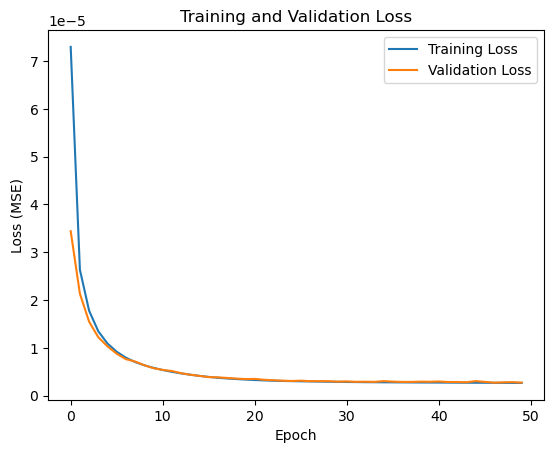

In [26]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.legend()
plt.show()

In [27]:
save_model(autoencoder,'autoencoder_model_cuslr_linear_e50_b64_10pv_vec1000_real.keras')

4707/4707 [==============================] - 4s 735us/step


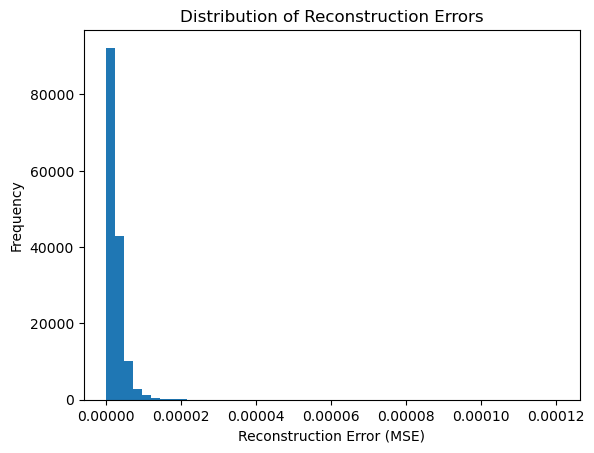

In [28]:
n_samples = 5
test_samples = np.array(X_train_v1)
reconstructed_samples = autoencoder.predict(test_samples)

# Flatten the input and output for comparison
X_test_flat = np.array(X_train_v1).reshape(len(X_train_v1), -1)
recon_flat = reconstructed_samples.reshape(len(reconstructed_samples), -1)

# Compute MSE for each sample
mse_scores = np.mean(np.square(X_test_flat - recon_flat), axis=1)

# Plot distribution of MSE
plt.hist(mse_scores, bins=50)
plt.xlabel("Reconstruction Error (MSE)")
plt.ylabel("Frequency")
plt.title("Distribution of Reconstruction Errors")
plt.show()

1/1 [==============================] - 0s 9ms/step


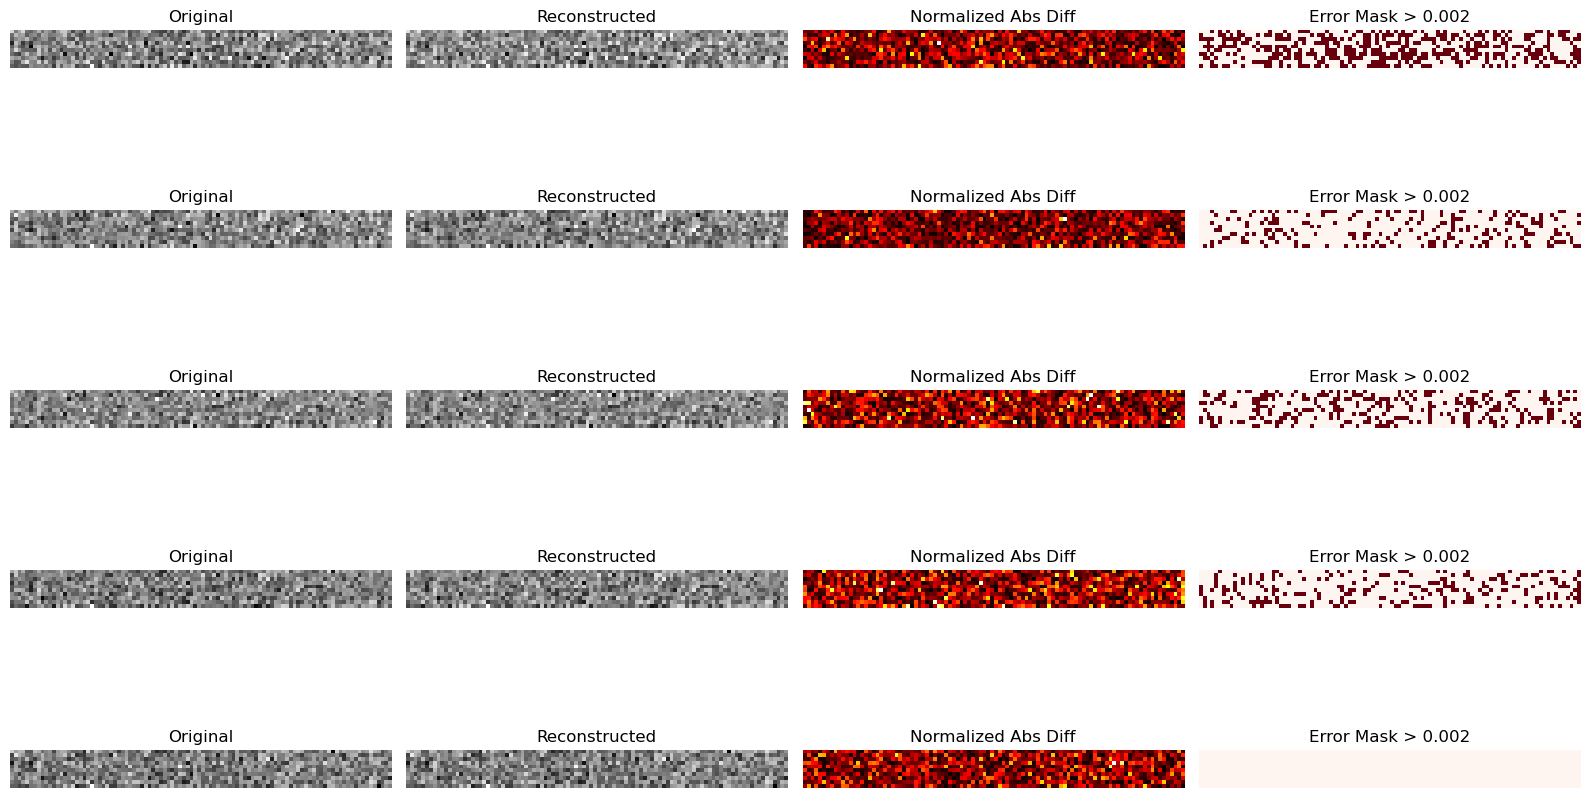

Original: [ 4.77496982e-02 -4.28433903e-03  1.85939912e-02  4.53363396e-02
 -1.01357047e-02 -1.74969435e-02 -1.42758086e-04  2.53588986e-02
 -9.72951110e-03  1.36292391e-02  3.96038545e-03 -2.13679988e-02
  1.41592575e-02  3.61544751e-02  3.78299765e-02  1.00990534e-02
 -3.19764130e-02  2.03529443e-03 -1.09500671e-02 -3.64939719e-02
  3.95309664e-02 -1.17355213e-02  2.84014884e-02  1.66139212e-02
 -1.80321280e-03  3.45865637e-03  3.11570913e-02 -7.68771349e-03
 -9.38853715e-03 -1.42767681e-02  1.55692808e-02 -2.52980441e-02
 -1.17891552e-02 -1.81117374e-02  1.83333382e-02  2.32175216e-02
  4.15120907e-02 -2.03580577e-02 -2.63172779e-02 -3.43197659e-02
 -3.75082381e-02  2.18003592e-03 -3.16261612e-02  2.68405378e-02
 -1.50178028e-02 -4.46474552e-02 -1.92538649e-02  3.02549060e-02
  9.05614719e-03  3.45607847e-02 -1.54956244e-02 -1.87679734e-02
 -1.48701072e-02 -1.52106099e-02  4.26212139e-02 -6.51839003e-03
  2.52293074e-03 -2.33823154e-02 -3.23944315e-02 -1.40170415e-03
 -3.19414586e-0

In [51]:
# n_samples = 5
# test_samples = np.array(X_train_v1)[np.random.choice(len(X_train_v1),n_samples, replace=False)]

# reconstructed_samples = autoencoder.predict(test_samples)
# fig, axes = plt.subplots(n_samples, 2, figsize=(8, 2 * n_samples))

# for i in range(n_samples):
#     axes[i, 0].imshow(test_samples[i].reshape(10,100), cmap="gray")  # Modify shape for your data
#     axes[i, 0].set_title("Original")
#     axes[i, 0].axis("off")

#     axes[i, 1].imshow(reconstructed_samples[i].reshape(10, 100), cmap="gray")  # Modify shape for your data
#     axes[i, 1].set_title("Reconstructed")
#     axes[i, 1].axis("off")

# plt.tight_layout()
# plt.show()
# for i in range(len(test_samples)):
#     print(test_samples[i])
#     print(reconstructed_samples[i])
#     print()
n_samples = 5
threshold = 2e-3  # You can play with this

test_samples = np.array(X_train_v1)[np.random.choice(len(X_train_v1), n_samples, replace=False)]
reconstructed_samples = autoencoder.predict(test_samples)

fig, axes = plt.subplots(n_samples, 4, figsize=(16, 2 * n_samples))  # 4 columns now

for i in range(n_samples):
    original = test_samples[i].reshape(10, 100)
    reconstructed = reconstructed_samples[i].reshape(10, 100)
    diff = np.abs(original - reconstructed)

    # Normalized difference for visualization
    norm_diff = (diff - np.min(diff)) / (np.max(diff) - np.min(diff) + 1e-12)

    # Thresholded mask
    mask = (diff > threshold).astype(float)

    axes[i, 0].imshow(original, cmap="gray")
    axes[i, 0].set_title("Original")
    axes[i, 0].axis("off")

    axes[i, 1].imshow(reconstructed, cmap="gray")
    axes[i, 1].set_title("Reconstructed")
    axes[i, 1].axis("off")

    axes[i, 2].imshow(norm_diff, cmap="hot")
    axes[i, 2].set_title("Normalized Abs Diff")
    axes[i, 2].axis("off")

    axes[i, 3].imshow(mask, cmap="Reds")  # Red = significant error
    axes[i, 3].set_title(f"Error Mask > {threshold}")
    axes[i, 3].axis("off")

plt.tight_layout()
plt.show()

for i in range(n_samples):
    print("Original:", test_samples[i])
    print("Reconstructed:", reconstructed_samples[i])
    print("Abs Difference:", np.abs(test_samples[i] - reconstructed_samples[i]))
    print()

In [52]:
# print(np.array(X_train_v1.shape)) 
# autoencoder = tf.keras.models.load_model('autoencoder_model_cuslr_linear_e5_b64_10pv.keras')
autoencoder = tf.keras.models.load_model('autoencoder_model_cuslr_linear_e50_b64_10pv_vec1000_real.keras')
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1000)]            0         
                                                                 
 dense (Dense)               (None, 512)               512512    
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 256)               33024     
                                                                 
 dense_4 (Dense)             (None, 512)               131584    
                                                                 
 dense_5 (Dense)             (None, 1000)              513000

In [53]:
# latent_layer = autoencoder.get_layer('dense_33')
latent_layer = autoencoder.get_layer('dense_2')
encoder = Model(inputs=autoencoder.input, outputs=latent_layer.output)
output_layer = autoencoder.get_layer('dense_5')
decoder = Model(inputs=latent_layer.input, outputs=output_layer.output)

In [65]:
# latent_representation = encoder.predict(X_train_v1,batch_size=32)
latent_representation = encoder.predict(np.concatenate((X_train_v1, X_val_v1), axis=0),batch_size=32)
# print(np.concatenate((X_train_v1, X_val_v1), axis=0).shape)

5883/5883 [==============================] - 3s 574us/step


In [66]:
print(latent_representation.shape)

(188243, 128)


In [67]:
sample = latent_representation

In [68]:
normed_sample = sample/(np.linalg.norm(sample,axis=1,keepdims=True)+1e-12)

In [69]:
knn = NearestNeighbors(n_neighbors=6, metric='cosine', algorithm='auto')
knn.fit(normed_sample)

NearestNeighbors(metric='cosine', n_neighbors=6)

In [70]:
s1 = np.array(averaged_recipe_list.loc[0,:]).reshape(1,-1)
encoded_input = encoder.predict(s1)
encoded_input /= (np.linalg.norm(encoded_input)+1e-12)  # normalize

# 3.2 Find nearest neighbors
distances, indices = knn.kneighbors(encoded_input)
print(f"Original Recipe: {df.loc[0]}")
# 3.3 Decode the top neighbors
for i, (idx, dist) in enumerate(zip(indices[0][1:], distances[0][1:])):  # skip self
    # substitute = decoder.predict(sample[idx].reshape(1, -1))
    substitute = df.loc[idx]
    print(f"\nSubstitute #{i+1} (similarity ≈ {1 - dist:.2f}):")
    print(substitute)

1/1 [==============================] - 0s 12ms/step
Original Recipe: ["brown sugar", "milk", "vanilla", "nuts", "butter", "bite size shredded rice biscuits"]

Substitute #1 (similarity ≈ 1.00):
["cranberries", "sugar", "pineapple", "marshmallows", "nuts"]

Substitute #2 (similarity ≈ 1.00):
["cherry pie filling", "pineapple", "milk", "nuts"]

Substitute #3 (similarity ≈ 1.00):
["potatoes", "water", "onion", "carrots", "margarine", "chicken bouillon granules", "pepper", "paprika", "milk", "parsley", "chives", "flour", "grated yellow"]

Substitute #4 (similarity ≈ 1.00):
["butter", "sugar", "brown sugar", "eggs", "vanilla", "flour", "salt", "baking soda", "baking powder", "cinnamon", "cook kind", "raisins", "nuts"]

Substitute #5 (similarity ≈ 1.00):
["ham", "potatoes", "onions", "Cheddar cheese", "cream of mushroom soup", "salt"]


In [100]:
import random
def vectorize(recipe):
    errors = []
    issue_flag = False
    temp = []

    for ingredient in recipe:
        try:
            vector = model.wv[ingredient]
            norm = np.linalg.norm(vector)
            if norm == 0:
                normed_vector = vector/(1e-12)
            else:
                normed_vector = vector/ norm
            temp.append(normed_vector)
        except KeyError:
            # print(f"Key: {ingredient} not found")
            errors.append(recipe_ingredients[i])
            issue_flag = True
            break        
    if issue_flag:
        issue_flag = False
        print(f"Ingredient not found, skipping {recipe}")
        return ""
        
    res = np.mean(temp,axis=0)
    if type(res) == np.float64 and math.isnan(res):
        return ""
    else:
        return res
    
hits, total = 0,0
for recipe in random.sample(recipe_ingredients,20):
    missing = recipe.pop(random.randint(1,len(recipe)-1))
    vector = np.array(vectorize(recipe)).reshape(1,-1)
    if vector.shape[1] == 1:
        continue
    query = encoder.predict(vector)
    nn_idx = knn.kneighbors(query, return_distance=False)[0][1:]
    neighbours = [df[index] for index in nn_idx]
    hits += any(missing in n for n in neighbours)
    total += 1
print(f"Hits = {hits}, total = {total}, hit rate = {hits/total}")

1/1 [==============================] - 0s 10ms/step
Ingredient not found, skipping ['sweet', 'onion', 'spaghetti sauce', 'water', 'ridged mostaccioli', 'mozzarella cheese', 'parmesan cheese']
1/1 [==============================] - 0s 9ms/step
Hits = 7, total = 19, hit rate = 0.3684210526315789
